In [1]:
import os
import pandas as pd
import numpy as np

In [ ]:
# Load and check the dataset

df = pd.read_csv('us_retail_sales.csv')
df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1992,146925,147223,146805,148032,149010,149800,150761.0,151067.0,152588.0,153521.0,153583.0,155614.0
1,1993,157555,156266,154752,158979,160605,160127,162816.0,162506.0,163258.0,164685.0,166594.0,168161.0
2,1994,167518,169649,172766,173106,172329,174241,174781.0,177295.0,178787.0,180561.0,180703.0,181524.0
3,1995,182413,179488,181013,181686,183536,186081,185431.0,186806.0,187366.0,186565.0,189055.0,190774.0
4,1996,189135,192266,194029,194744,196205,196136,196187.0,196218.0,198859.0,200509.0,200174.0,201284.0


In [5]:
# Checking for missing data

nans = df.isnull().values.any()
print(nans)

True


In [6]:
df.isnull().sum()

YEAR    0
JAN     0
FEB     0
MAR     0
APR     0
MAY     0
JUN     0
JUL     1
AUG     1
SEP     1
OCT     1
NOV     1
DEC     1
dtype: int64

In [8]:
df.tail(10)

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
20,2012,352862,357379,358719,356849,356018,352043,353891.0,358450.0,361470.0,361991.0,362876.0,364488.0
21,2013,367009,372291,369081,367514,369493,371041,373554.0,372489.0,372505.0,373663.0,373914.0,377032.0
22,2014,373033,378581,382601,386689,387100,388106,388359.0,391305.0,389860.0,390506.0,391805.0,388569.0
23,2015,385648,385157,391420,391356,394718,395464,398193.0,398105.0,396248.0,394503.0,396240.0,397052.0
24,2016,394749,398105,396911,398190,400143,404756,403730.0,403968.0,405958.0,407395.0,406061.0,412610.0
25,2017,416081,415503,414620,416889,414540,416505,416744.0,417179.0,426501.0,426933.0,431158.0,433282.0
26,2018,432148,434106,433232,435610,439996,438191,440703.0,439278.0,438985.0,444038.0,445242.0,434803.0
27,2019,440751,439996,447167,448709,449552,450927,454012.0,456500.0,452849.0,455486.0,457658.0,458055.0
28,2020,460586,459610,434281,379892,444631,476343,481627.0,483716.0,493327.0,493991.0,488652.0,484782.0
29,2021,520162,504458,559871,562269,548987,550782,NaN,NaN,NaN,NaN,NaN,NaN


It looks like our missing data is all from July-December of 2021, the last year in which data was available in this dataset. We won't need to worry about dropping NAs or imputing missing values. We can just ignore the last 6 months of the dataset. We will, however, need to transform this datset into long format so that things are simpler going forward, especially since we are doing a time series analysis with this data. 

In [ ]:
# Melting to long format so that there's one row per (year, month)

df_long = pd.melt(
    df,
    id_vars=['YEAR'],
    value_vars=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],
    var_name='MONTH',
    value_name='SALES'
)

In [ ]:
# Mapping the three‑letter month names to month numbers

month_map = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4,
    'MAY': 5, 'JUN': 6, 'JUL': 7, 'AUG': 8,
    'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}
df_long['month_num'] = df_long['MONTH'].map(month_map)

In [11]:
# Building a proper datetime index, we'll just use the first day of each month for this

df_long['DATE'] = pd.to_datetime({
    'year':  df_long['YEAR'],
    'month': df_long['month_num'],
    'day':   1
})
df_long = df_long.set_index('DATE').sort_index()

df_long.head()

,YEAR,MONTH,SALES,month_num
DATE,,,,
1992-01-01,1992,JAN,146925.0,1
1992-02-01,1992,FEB,147223.0,2
1992-03-01,1992,MAR,146805.0,3
1992-04-01,1992,APR,148032.0,4
1992-05-01,1992,MAY,149010.0,5


In [13]:
# Looking good. Now let's get a train/test splits

start_test = pd.to_datetime('2020-07-01')
end_test   = pd.to_datetime('2021-06-30')

# Now comparing index to those timestamps

train = df_long.loc[df_long.index < start_test, 'SALES']
test  = df_long.loc[
    (df_long.index >= start_test) &
    (df_long.index <= end_test),
    'SALES'
]

In [14]:
print(f"Training covers {train.index.min().date()} to {train.index.max().date()}")
print(f"Testing  covers {test.index.min().date()} to {test.index.max().date()}")

Training covers 1992-01-01 to 2020-06-01
Testing  covers 2020-07-01 to 2021-06-01


Perfect! Since this is a time series, let's plot a simple line graph to see what we can see over the entire span of the dataset. 

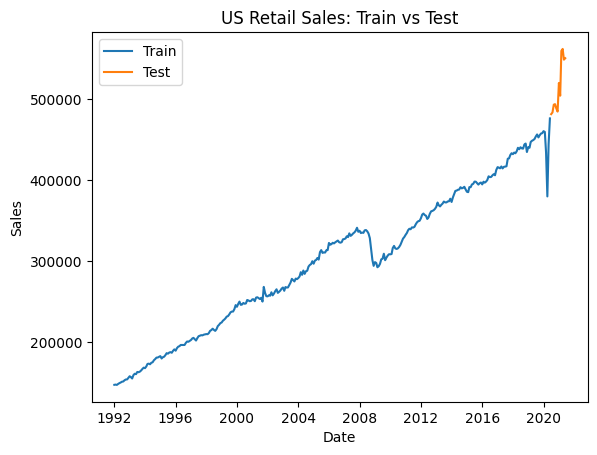

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train.index, train, label='Train')   # because train is a pd.Series
plt.plot(test.index,  test,  label='Test')    # test is also a pd.Series
plt.title('US Retail Sales: Train vs Test')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
# Now to build and train a predictive model on the training set. I think I'll stick with a more basic SARIMA model for now 
# and see how well it performs. But first we'll get our hyperparamaters optimized by doing a grid search

import itertools
import statsmodels.api as sm

# defining search space to auto-tune the hyperparamaters
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

best_aic = np.inf
best_params = None

for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            res = mod.fit(disp=False)
            if res.aic < best_aic:
                best_aic = res.aic
                best_params = (order, seasonal_order)
        except Exception:
            continue

print("Best SARIMA{}x{}12 AIC={:.1f}".format(best_params[0], best_params[1], best_aic))

Best SARIMA(1, 1, 1)x(1, 1, 1, 12)12 AIC=6430.4


In [23]:
# Now to fit the model with these parameters

model = sm.tsa.statespace.SARIMAX(
    train,
    order=(1, 1, 1),                   # non‑seasonal (p,d,q)
    seasonal_order=(1, 1, 1, 12),      # seasonal (P,D,Q,s)
    enforce_stationarity=False,        # to allow the solver more freedom
    enforce_invertibility=False
)

results = model.fit(disp=False)       # disp=False silences convergence output

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              SALES   No. Observations:                  342
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3210.179
Date:                            Fri, 25 Jul 2025   AIC                           6430.359
Time:                                    13:58:44   BIC                           6449.122
Sample:                                01-01-1992   HQIC                          6437.855
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5570      0.083      6.676      0.000       0.393       0.721
ma.L1         -0.7234      0.079   

In [24]:
# Model is fit with the optimal parameters. Now let's use it to predict the US retail sales for the hold out period (next 12 months)

# Forecast n_periods steps ahead (test)
n_periods = len(test)  
forecast = results.get_forecast(steps=n_periods)

# getting the point forecasts:
y_pred = forecast.predicted_mean

# 95% confidence intervals:
conf_int = forecast.conf_int()

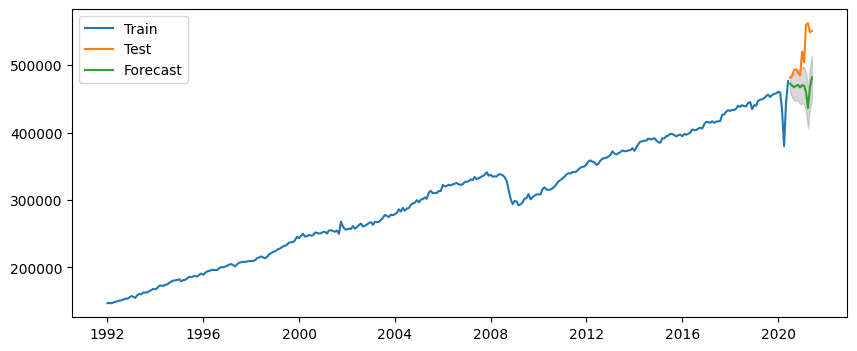

In [25]:
# Now let's plot our predictions and see how we did

plt.figure(figsize=(10, 4))
plt.plot(train.index, train, label='Train')         # plotting the training set
plt.plot(test.index, test, label='Test')            # plotting the testing set
plt.plot(y_pred.index, y_pred, label='Forecast')    # plotting our predictions as 'Forecast'
plt.fill_between(
    conf_int.index,         # confidence interval for the forecasts
    conf_int.iloc[:, 0],    # lower bound of the confidence interval 
    conf_int.iloc[:, 1],    # upper bound of the confidence interval
    color='gray', alpha=0.3 # filling in the confidence intervals with gray
)
plt.legend()
plt.show()

We can clearly see from the plot that our predictions were significantly off from the actual US retail sales data recorded for this time period. I have a feeling that the timing of the test set has a lot to do with this. Remembering this time period, unprecedented government action was taken in the form of multiple stimulus checks which were meant to keep the economy from crashing entirely as a result of the pandemic. We obviously have not provided our model with a way to take that into consideration and as such, its predictions are way off from what actually happened. Nonetheless, let's get our RMSE so we can quantify our model's performance more concretely. 

In [26]:
# Will use sklearn to compute the RMSE for the model

from sklearn.metrics import mean_squared_error

# Generating out‑of‑sample forecasts for the test set length
n_periods = len(test)
forecast = results.get_forecast(steps=n_periods)
y_pred = forecast.predicted_mean

# Computing RMSE
rmse = np.sqrt(mean_squared_error(test, y_pred)) # taking the square root of the MSE
print(f'Test RMSE: {rmse:.2f}')

Test RMSE: 59819.07


This RMSE shows that the model is off by quite a bit in the test period. This indicates that there were clearly significant shocks in the hold-out period that the model just couldn't anticipate. This coincides with unprecedented pandemic-related lockdowns, recoveries and stimulus checks. I think a more involved model that takes into account the complexities of the Covid pandemic would be better at predicting US retail sales during this time period. 

References: 

Brownlee, J. (2019, August 21). A Gentle Introduction to SARIMA for Time Series Forecasting in Python. Machine Learning Mastery. Retrieved July 25, 2025, from https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/